# Feature detection

This notebook shows the research process of replacing HOG with smarter SIFT feature detection in our ecocup classifier.

## Toy example

In [2]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import transform
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, SIFT


In [3]:
img1 = rgb2gray(data.astronaut())

In [4]:
descriptor_extractor = SIFT()
descriptor_extractor.detect_and_extract(img1)

keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors


Text(0.5, 1.0, 'SIFT keypoints')

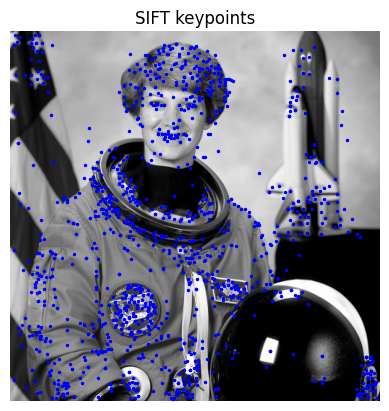

In [5]:
# plot keypoints
fig, ax = plt.subplots()
plt.gray()

ax.imshow(img1)
ax.plot(keypoints1[:, 1], keypoints1[:, 0], '.b', markersize=3)
ax.axis('off')
ax.set_title('SIFT keypoints')

In [6]:
descriptors1

array([[ 20,  19, 107, ...,   0,   8,  31],
       [  0,   0,   0, ...,   3,   9,  82],
       [  0,   0,   0, ...,   0,   0,  25],
       ...,
       [  0,   4,   4, ...,   4,   1,   4],
       [ 97, 118,   0, ...,   3,  12,   7],
       [ 34,   7,  11, ...,  99,  34,  17]], dtype=uint8)

## K-means clustering of SIFT features

We want to cluster the SIFT features to classify the images. We will compute the SIFT features for all images in the dataset and then cluster them using k-means.

### Compute SIFT features for all images

In [11]:
import os
import numpy as np
from skimage import io
from tqdm.notebook import tqdm

In [8]:
# load images
pos_images = []
for file in os.listdir('data/augmented_images'):
    if file.endswith('.jpg'):
        pos_images.append(rgb2gray(io.imread('data/augmented_images/' + file)))

neg_images = []
for file in os.listdir('data/negative_images'):
    if file.endswith('.jpg'):
        neg_images.append(rgb2gray(io.imread('data/negative_images/' + file)))

  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

No features found in 214 images


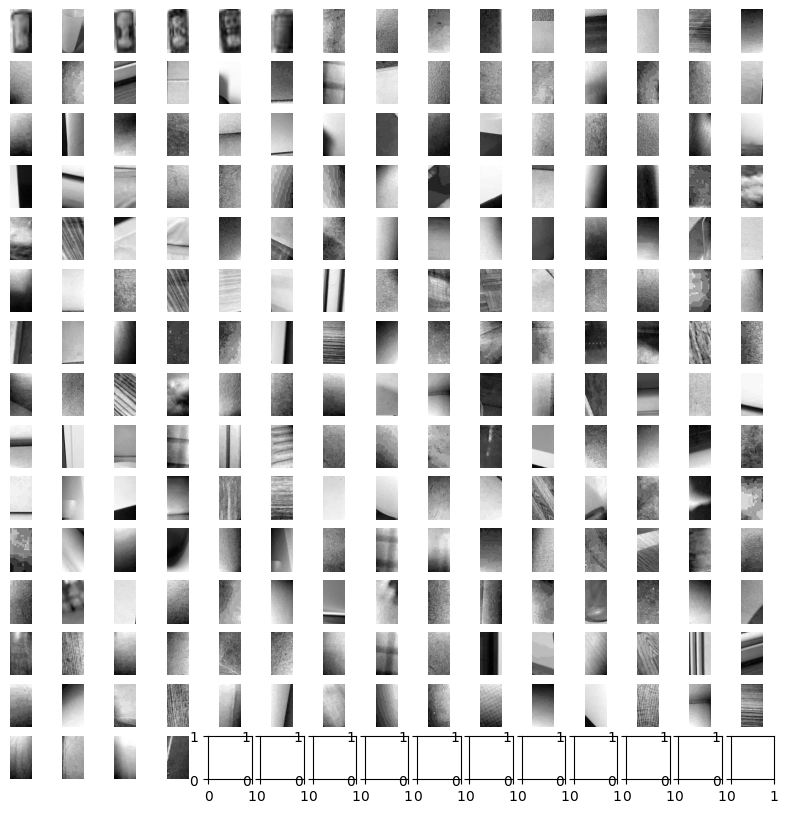

In [63]:
# compute SIFT features
descriptor_extractor = SIFT()

errored_images = []
pos_descriptors = []
pos_features = []
for img in tqdm(pos_images):
    try:
        descriptor_extractor.detect_and_extract(img)
    except:
        errored_images.append(img)
        continue
    pos_descriptors.append(descriptor_extractor.descriptors)

neg_descriptors = []
neg_features = []
for img in tqdm(neg_images):
    try:
        descriptor_extractor.detect_and_extract(img)
    except:
        errored_images.append(img)
        continue
    neg_descriptors.append(descriptor_extractor.descriptors)

# plot errored images
print(f'No features found in {len(errored_images)} images')
square = int(np.ceil(np.sqrt(len(errored_images))))
fig, ax = plt.subplots(square, square, figsize=(10, 10))
for i, img in enumerate(errored_images):
    ax[i // square, i % square].imshow(img)
    ax[i // square, i % square].axis('off')

Text(0.5, 1.0, 'SIFT keypoints')

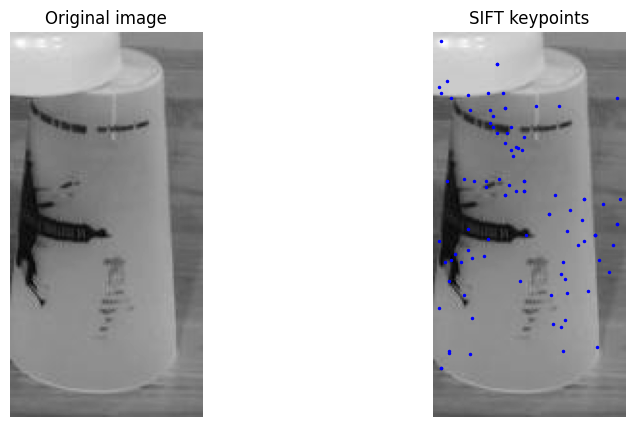

In [44]:
# plot an example of SIFT features
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pos_images[12])
ax[0].axis('off')
ax[0].set_title('Original image')
ax[1].imshow(pos_images[12])
ax[1].plot(descriptor_extractor.keypoints[:, 1], descriptor_extractor.keypoints[:, 0], '.b', markersize=3)
ax[1].axis('off')
ax[1].set_title('SIFT keypoints')

In [68]:
# flatten descriptors
pos_descriptors = [desc.flatten() for desc in tqdm(pos_descriptors)]
neg_descriptors = [desc.flatten() for desc in tqdm(neg_descriptors)]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

In [69]:
neg_descriptors[1].shape

(9856,)

In [73]:
# reduce dimensionality of SIFT features to 128 using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
pos_features = []
for desc in pos_descriptors:
    pos_features.append(pca.fit_transform(desc))

neg_features = []
for desc in neg_descriptors:
    neg_features.append(pca.fit_transform(desc))

ValueError: Expected 2D array, got 1D array instead:
array=[83.  0.  0. ... 16.  9. 12.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [35]:
pos_features[3].shape

(153, 128)